# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## <font color='brown'>Problem Statement</font>

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.


The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- **Thumbs up**:  Increase the volume
- **Thumbs down**: Decrease the volume
- **Left swipe**: 'Jump' backwards 10 seconds
- **Right swipe*: 'Jump' forward 10 seconds  
- **Stop**: Pause the movie


Each video is a sequence of 30 frames (or images)

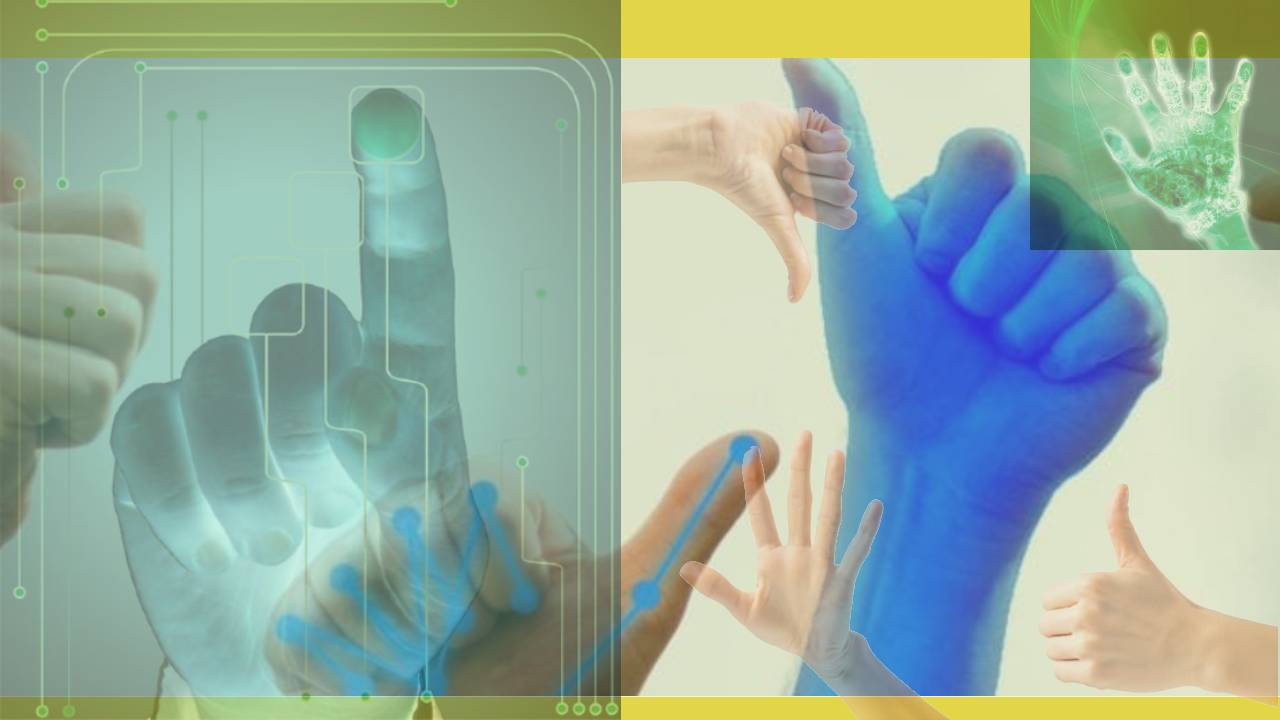

### The dataset

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

### Goals of the project

In this project, we will build a model to recognise 5 hand gestures. We need to accomplish the following in the project:

- **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

- **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

- **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

### Steps to perform

We will perform a series of experiments by adjusting and modifying different hyperparameters like image resolution, batch size, number of layers, adding dropouts, using different netwroks etc and observing the loss and accuracy values of each experiment's outcome until we arrive at the most optimal solution.

In [1]:
! gdown --id 1Io3_KHIr3VGr2Wa7Do48YeKyydgvxqo5

Downloading...
From: https://drive.google.com/uc?id=1Io3_KHIr3VGr2Wa7Do48YeKyydgvxqo5
To: /content/data.zip
100% 1.71G/1.71G [00:06<00:00, 253MB/s]


In [2]:
!7z x data.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1705807031 bytes (1627 MiB)

Extracting archive: data.zip
 17% 4096 Open              --
Path = data.zip
Type = zip
Physical Size = 1705807031

  0%      0% 104 - data/train/WIN_20180907_15_38_ . 0180907_15_38_35_Pro_00024.png                                                                            1% 210 - data/train/WIN_20180907_15_40_ . 0180907_15_40_26_Pro_00041.png                                                                          

##### Let us first import the requitred libraries

In [3]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import datetime
import os

**Please Note**:- Since the starter code had some package that are deprecated or removed in current version, hence we have an option to either downgrade to previous version or use the library compatible with current version, hence we will use an alternative libary of the current version in few instances which would actually serve the same purpose. As an example the library imread and imresize of scipy given in the above code is no longer supported in the latest version of scipy hence we have commented it out and instead will be using the imread library from skimage package.

We set the random seed so that the results don't vary drastically.

In [55]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from skimage.io import imread
from skimage import transform,exposure
from skimage.transform import rotate, AffineTransform

<font color='red'>We keep the following codes given below as commented and this code needs to be executed when the GPU memory is not enough to disable the GPU and use CPU instead else a dead terminal issue may occur.</font>

In [5]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/content/data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
x = 30 # total number of frames in each sequence
y = 120 # the image width
z = 120 # the image height
SAMPLE_FRAMES = 30 # number of frames to use from each sequence

#### Let us define the generator given in the starter code

In [8]:
# Define generator function
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.linspace(0,x-1,SAMPLE_FRAMES).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #normalized_image=imresize(image,(120, 120,3))
                    normalized_image= transform.resize(image, output_shape=(y, z, 3))
                    batch_data[folder,idx,:,:,0] = (normalized_image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (normalized_image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (normalized_image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    normalized_image= transform.resize(image, output_shape=(y, z, 3))
                    batch_data[folder,idx,:,:,0] = (normalized_image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (normalized_image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (normalized_image[:,:,2])/255
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = 'data/train'
val_path = 'data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

#write your model here
# First model
model = Sequential()
model.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the Layers
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 8)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 16)   6

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 4.6690 - categorical_accuracy: 0.2986Source path =  data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-12-2609_01_31.287712/model-00001-4.66899-0.29864-1.60895-0.22000.h5
67/67 [==============================] - 207s 3s/step - loss: 4.6690 - categorical_accuracy: 0.2986 - val_loss: 1.6090 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 2.4515 - categorical_accuracy: 0.2637
Epoch 00002: saving model to model_init_2021-12-2609_01_31.287712/model-00002-2.45153-0.26368-1.98488-0.22000.h5
67/67 [==============================] - 72s 1s/step - loss: 2.4515 - categorical_accuracy: 0.2637 - val_loss: 1.9849 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 2.0666 - categorical_accuracy: 0.2488
Epoch 00003: saving model to model_in

In [16]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['Loss','Validation Loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['Categorical Tarining Accuracy','Validation Categorical Accuracy'])

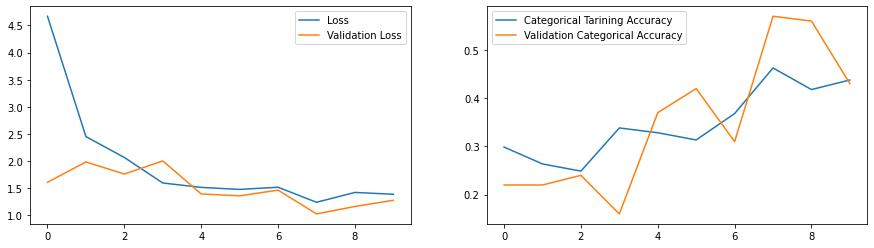

In [17]:
plot(model.history)

#### Sample resized and cropped image

Source path =  data/train ; batch size = 10


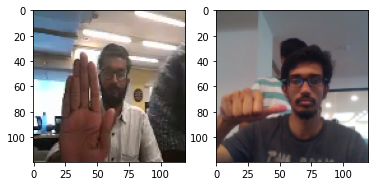

In [18]:
# get the yeild from the generator and plot the sample cropped and scaled image
yeild_value= generator(train_path, train_doc, batch_size)
batch_data1, batch_labels1=next(yeild_value)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data1[0,15,:,:,:])   
axes[1].imshow(batch_data1[3,15,:,:,:]) 

### Let us define a custom class called ModelExecutor

Let us create a class called **ModelExecuter**. This class contains all the required methods to calculate the steps, generator, execute the model and plot the graphs for loss and accuracy for both tarining and validation datasets.

Going forward we will define each different models wrapped in a class and the intstance of this model would be fed to this ModelExecutor class.

In [19]:
# Define ModelExecutor class
class ModelExecutor:
    def __init__(self, base_folder):
        self.train_doc = np.random.permutation(open(base_folder+'/train.csv').readlines())
        self.val_doc = np.random.permutation(open(base_folder+'/val.csv').readlines())
        self.train_path = base_folder+'/train'
        self.val_path = base_folder+'/val'
        self.num_train_sequences = len(self.train_doc)
        print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(self.val_doc)
        print('# validation sequences =', self.num_val_sequences)

    
    def executeModel(self, model, parameters):
        self.model = model
        self.x=parameters['x']
        self.y=parameters['y']
        self.z=parameters['z']
        self.sample_frames=parameters['sample_frames']
        self.batch_size=parameters['batch_size']
        self.num_epochs=parameters['num_epochs']
        self.augmentMode = parameters['augmentMode']
        print ('# epochs =', self.num_epochs)
        self.callbacks_list= parameters["callbacks_list"]
        self.train_generator = self.generator(self.train_path, self.train_doc)
        self.val_generator = self.generator(self.val_path, self.val_doc)
        self.calculate_steps(self.batch_size)
        self.train_model()

    
    def calculate_steps(self, batch_size):
        if (self.num_train_sequences%batch_size) == 0:
            self.steps_per_epoch = int(self.num_train_sequences/batch_size)
        else:
            self.steps_per_epoch = (self.num_train_sequences//batch_size) + 1
        if (self.num_val_sequences%batch_size) == 0:
            self.validation_steps = int(self.num_val_sequences/batch_size)
        else:
            self.validation_steps = (self.num_val_sequences//batch_size) + 1
    
    def train_model(self):
        self.model.fit_generator(self.train_generator, steps_per_epoch=self.steps_per_epoch, epochs=self.num_epochs,
                    verbose=1, callbacks=self.callbacks_list, validation_data=self.val_generator, 
                    validation_steps=self.validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    def plot(self):
        history = self.model.history
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(history.history['loss'])   
        axes[0].plot(history.history['val_loss'])
        axes[0].legend(['Loss','Validation Loss'])
        axes[1].plot(history.history['categorical_accuracy'])   
        axes[1].plot(history.history['val_categorical_accuracy'])
        axes[1].legend(['Categorical Training Accuracy','Validation Categorical Accuracy'])
    
    def generator(self, source_path, folder_list):
        print( 'Source path = ', source_path, '; batch size =', self.batch_size)
        img_idx = np.linspace(0,x-1,self.sample_frames).astype(int) #create a list of image numbers you want to use for a particular video
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//self.batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((self.batch_size,self.x,self.y,self.z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((self.batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(self.batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*self.batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        normalized_image= transform.resize(image, output_shape=(self.y, self.z, 3))
                        batch_data[folder,idx,:,:,0] = (normalized_image[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (normalized_image[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (normalized_image[:,:,2])/255

                    batch_labels[folder, int(t[folder + (batch*self.batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


            # write the code for the remaining data points which are left after full batches
            if (len(folder_list) != self.batch_size*num_batches):
                print("Batch: ",num_batches+1,"Index:", self.batch_size)
                batch_size = len(folder_list) - (self.batch_size*num_batches)
                batch_data = np.zeros((self.batch_size,self.x,self.y,self.z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((self.batch_size,5)) # batch_labels is the one hot representation of the output

                # Add the option to apply augmentation if the augmentation flag is set to True
                if (self.augmentMode):
                  batch_data_augmented = np.zeros((self.batch_size,self.x,self.y,self.z,3))
                
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*self.batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        normalized_image= transform.resize(image, output_shape=(self.y, self.z, 3))
                        batch_data[folder,idx,:,:,0] = (normalized_image[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (normalized_image[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (normalized_image[:,:,2])/255

                        if(self.augmentMode):
                          tf = AffineTransform(shear=-0.3)
                          sheared_image = transform.warp(normalized_image, tf, order=1, preserve_range=True, mode='wrap')  # Shear the image
                          bright_image = exposure.adjust_gamma(sheared_image, gamma=0.5,gain=1) # increase the brightness of the image
                          rotated_image = rotate(bright_image, angle=np.random.randint(-12,12)) # rotate the image by 12 degrees

                          batch_data_augmented[folder,idx,:,:,0] = (rotated_image[:,:,0])/255
                          batch_data_augmented[folder,idx,:,:,1] = (rotated_image[:,:,1])/255
                          batch_data_augmented[folder,idx,:,:,2] = (rotated_image[:,:,2])/255

                    batch_labels[folder, int(t[folder + (batch*self.batch_size)].strip().split(';')[2])] = 1

                if (self.augmentMode):
                  batch_data=np.concatenate([batch_data,batch_data_augmented])
                  batch_labels=np.concatenate([batch_labels,batch_labels])
                
                yield batch_data, batch_labels
        

#### Let us also define a method ***modelBuildAndExecute** function that will perform the following steps:

- Instantiate and build the model
- Display the model summary
- Feed this model to the modelExecutor for processing the model
- Plot the loss and accuracy graph (this can be switched off also if required by setting plot=False)

In [20]:
def modelBuildAndExecute(model, parameters, plot=True, augmentMode=False):
    parameters['augmentMode'] = augmentMode
    model1 = model(parameters).build()
    print (model1.summary())
    modelExecutor.executeModel( model1, parameters)
    if(plot):
        modelExecutor.plot()

### Experimenting with Image resolution, number of frames to use and batch_size

#### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

#### Let us take the parameters in a dictionary object containing all the required parameters. We will keep updating these parameters , feed to the model and train the model based on these parameters.

In [21]:
parameters={
    'x':30,
    'y':100,
    'z':100,
    'sample_frames':30,
    'batch_size':30,
    'num_epochs':2,
    'callbacks_list':callbacks_list
}

In [22]:
base_folder = 'data'

In [23]:
modelExecutor = ModelExecutor(base_folder)

# training sequences = 663
# validation sequences = 100


### <font color='#12558A'>Experiment number 1</font>
<font style="font-size:16px">Let us experiment by modifying batch size, image resolution and frames to sample and observe its impact on the training time as well.</font>

In [24]:
# Define the first model class
class Model1:
    def __init__(self, parameters): 
        model = Sequential()
        model.add(Conv3D(8, #number of filters 
                         kernel_size=(3,3,3), 
                         input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3),
                         padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Conv3D(16, #Number of filters, 
                         kernel_size=(3,3,3), 
                         padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Conv3D(32, #Number of filters 
                         kernel_size=(1,3,3), 
                         padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Conv3D(64, #Number pf filters 
                         kernel_size=(1,3,3), 
                         padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        # Flatten the Layers
        model.add(Flatten())
        model.add(Dense(1000, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.5))

        #softmax layer
        model.add(Dense(5, activation='softmax'))
        optimiser = Adam(lr=0.001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        self.model = model
        
    def build(self):
        return self.model

##### Execute the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 100, 100, 8)   656       
                                                                 
 batch_normalization_4 (Batc  (None, 30, 100, 100, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 30, 100, 100, 8)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 50, 50, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 50, 50, 16)    3472      
                                                                 
 batch_normalization_5 (Batc  (None, 15, 50, 50, 16)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 3.2540 - categorical_accuracy: 0.2556Source path =  data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 00001: saving model to model_init_2021-12-2609_01_31.287712/model-00001-3.25400-0.25556-1.22592-0.20000.h5
23/23 [==============================] - 186s 8s/step - loss: 3.2540 - categorical_accuracy: 0.2556 - val_loss: 1.2259 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.5825 - categorical_accuracy: 0.3583Batch:  4 Index: 30

Epoch 00002: saving model to model_init_2021-12-2609_01_31.287712/model-00002-1.58245-0.35833-1.31269-0.14000.h5
23/23 [==============================] - 176s 8s/step - loss: 1.5825 - categorical_accuracy: 0.3583 - val_loss: 1.3127 - val_categorical_accuracy: 0.1400 - lr: 0.0010


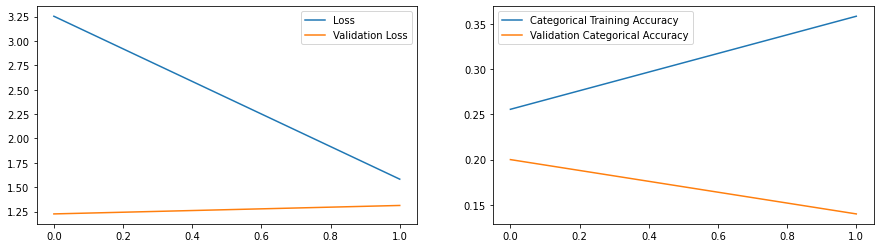

In [25]:
modelBuildAndExecute(Model1, parameters,augmentMode=True)

#### Now let us take frames to sample as 30 and the batch size as 20 and execute the model

In [26]:
# update the parameters
parameters['sample_frames']=30
parameters['batch_size']=20
parameters

{'augmentMode': True,
 'batch_size': 20,
 'callbacks_list': [<keras.callbacks.ModelCheckpoint at 0x7f9fe83bc350>,
 'num_epochs': 2,
 'sample_frames': 30,
 'x': 30,
 'y': 100,
 'z': 100}

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 100, 100, 8)   656       
                                                                 
 batch_normalization_8 (Batc  (None, 30, 100, 100, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 30, 100, 100, 8)   0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 50, 50, 8)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 16)    3472      
                                                                 
 batch_normalization_9 (Batc  (None, 15, 50, 50, 16)  

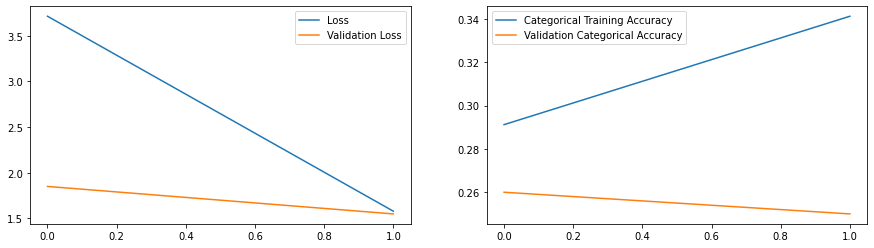

In [27]:
# Build the model
modelBuildAndExecute(Model1, parameters)

#### Now let us take dimension of the image as 160 width and height and execute the model

In [28]:
parameters['y']=160
parameters['z']=160
parameters

{'augmentMode': False,
 'batch_size': 20,
 'callbacks_list': [<keras.callbacks.ModelCheckpoint at 0x7f9fe83bc350>,
 'num_epochs': 2,
 'sample_frames': 30,
 'x': 30,
 'y': 160,
 'z': 160}

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 160, 160, 8)   656       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 8)  32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 30, 160, 160, 8)   0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 80, 80, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 80, 80, 16)    3472      
                                                                 
 batch_normalization_13 (Bat  (None, 15, 80, 80, 16)  

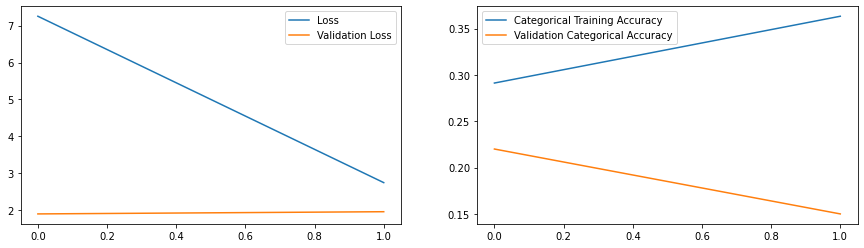

In [29]:
# Execute the model
modelBuildAndExecute(Model1, parameters)

#### Now let us take frames to sample as 16 and the batch size as 30 and execute the model

In [30]:
parameters['sample_frames']=16
parameters['batch_size']=30
parameters

{'augmentMode': False,
 'batch_size': 30,
 'callbacks_list': [<keras.callbacks.ModelCheckpoint at 0x7f9fe83bc350>,
 'num_epochs': 2,
 'sample_frames': 16,
 'x': 30,
 'y': 160,
 'z': 160}

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 160, 160, 8)   656       
                                                                 
 batch_normalization_16 (Bat  (None, 16, 160, 160, 8)  32        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 16, 160, 160, 8)   0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 80, 80, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 80, 80, 16)     3472      
                                                                 
 batch_normalization_17 (Bat  (None, 8, 80, 80, 16)   

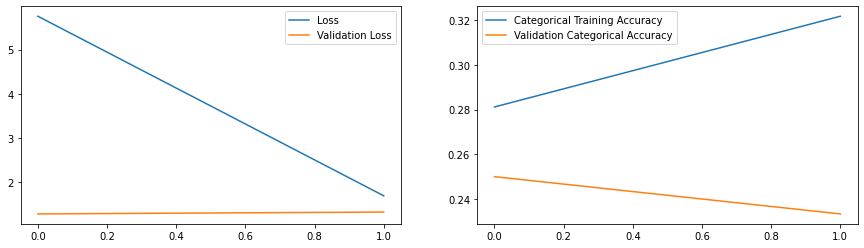

In [31]:
# Execute the model
modelBuildAndExecute(Model1, parameters)

---

#### We do not see any improvement in the model

### <font color='#12558A'>Experiment number 2</font>
<font style="font-size:16px">Let us experiment with base Model having batch Size of 40 and No. of Epochs = 15</font>

In [32]:
class Model2:
    def __init__(self, parameters): 
        model = Sequential()
        model.add(Conv3D(16, 
                         kernel_size=parameters['modelParams']['kernelSize'], 
                         input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3),
                         padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(parameters['modelParams']['dropout']))

        model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(parameters['modelParams']['dropout']))


        model.add(Dense(5,activation='softmax')) # five classes

        optimiser = parameters['modelParams']['optimiser']
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        self.model = model
        
    def build(self):
        return self.model

#### Now let us update the number of sample frames to 20, batch size to 40 and number of epochs to 15 and execute the model

In [33]:
parameters['sample_frames']=20
parameters['batch_size']=40
parameters['num_epochs']=15
parameters['callbacks_list']=[LR]
# Add model parameters to the parameters for use in the Model
modelParams={
    "neurons":64,
    "dropout":0.25,
    "kernelSize":(3,3,3),
    "optimiser":Adam()
}
parameters['modelParams']=modelParams
parameters

{'augmentMode': False,
 'batch_size': 40,
 'callbacks_list': [<keras.callbacks.ReduceLROnPlateau at 0x7fa066863810>],
 'modelParams': {'dropout': 0.25,
  'kernelSize': (3, 3, 3),
  'neurons': 64,
  'optimiser': <keras.optimizer_v2.adam.Adam at 0x7f9fc412efd0>},
 'num_epochs': 15,
 'sample_frames': 20,
 'x': 30,
 'y': 160,
 'z': 160}

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_21 (Activation)  (None, 10, 80, 80, 32)   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5764 - categorical_accuracy: 0.3809Source path =  data/val ; batch size = 40
Batch:  3 Index: 40
17/17 [==============================] - 151s 9s/step - loss: 1.5764 - categorical_accuracy: 0.3809 - val_loss: 1.8495 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - 142s 9s/step - loss: 1.0655 - categorical_accuracy: 0.5853 - val_loss: 2.5630 - val_categorical_accuracy: 0.1167 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8047 - categorical_accuracy: 0.6662Batch:  3 Index: 40
Batch:  3 Index: 40
17/17 [==============================] - 143s 9s/step - loss: 0.8047 - categorical_accuracy: 0.6662 - val_loss: 3.2153 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 4/15
17/17 [==============================] - 159s 10s/step - loss: 0.6768 - categorical_accuracy: 0.7382 - val_loss: 5.2842 - val_categorical_accuracy: 0.1333 - lr: 0.00

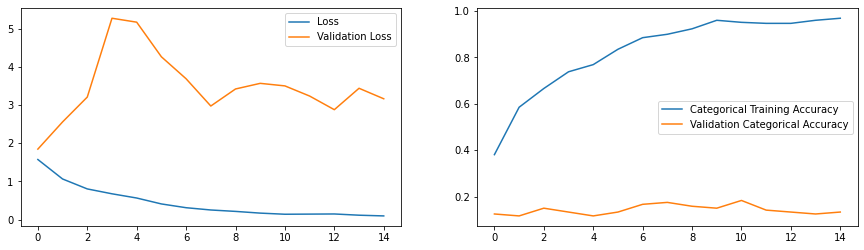

In [34]:
# Build the model
modelBuildAndExecute(Model2, parameters)

<font color='red'>Well we observe that the model is overfitting</font>

#### Now let us update the batch size as 20, number of epochs as 25, number of dense neurons we increase to 256 and droput value to be 0.5 and execute the model. Let us also implement early stopping parmeter to avoid further epoch processing if no improvements.

In [35]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
parameters['batch_size']=20
parameters['num_epochs']=25
parameters['callbacks_list']=[LR, earlystop]
# Add model parameters to the parameters for use in the Model
modelParams={
    "neurons":256,
    "dropout":0.5,
    "kernelSize":(3,3,3),
    "optimiser":Adam()
}
parameters['modelParams']=modelParams
parameters

{'augmentMode': False,
 'batch_size': 20,
 'callbacks_list': [<keras.callbacks.ReduceLROnPlateau at 0x7fa066863810>,
 'modelParams': {'dropout': 0.5,
  'kernelSize': (3, 3, 3),
  'neurons': 256,
  'optimiser': <keras.optimizer_v2.adam.Adam at 0x7f9fc52d3e50>},
 'num_epochs': 25,
 'sample_frames': 20,
 'x': 30,
 'y': 160,
 'z': 160}

In [ ]:
# Build the model
modelBuildAndExecute(Model2, parameters)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_26 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_25 (Activation)  (None, 10, 80, 80, 32)   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - 147s 4s/step - loss: 1.9516 - categorical_accuracy: 0.3735 - val_loss: 5.8530 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - 146s 4s/step - loss: 1.4576 - categorical_accuracy: 0.4647 - val_loss: 9.9216 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - 152s 5s/step - loss: 1.0773 - categorical_accuracy: 0.5926 - val_loss: 12.0513 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 4/25
34/34 [==============================] - 165s 5s/step - loss: 0.9386 - categorical_accuracy: 0.6544 - val_loss: 7.5816 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 5/25
34/34 [==============================] - ETA: 0s - loss: 0.9922 - categorical_accuracy: 0.6441
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
34/34 [==============================] - 164s 5s/step - loss: 0.9922 - categorical_accuracy: 0.6441 -

<font color="red"> The model is still overfitting</font>

### <font color='#12558A'>Experiment number 3</font>
<font style="font-size:16px">Let us now update the filter size to (2,2,2), image width and height to 120 and a batch Size of 30</font>

In [ ]:
parameters['batch_size']=30
parameters['y']=120
parameters['z']=120
parameters['modelParams']['kernelSize'] =(2,2,2)
parameters['modelParams']['optimiser'] = Adam(lr=0.0002)
parameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 20, 120, 120, 16)  400       
                                                                 
 activation_28 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_32 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_29 (Activation)  (None, 10, 60, 60, 32)   

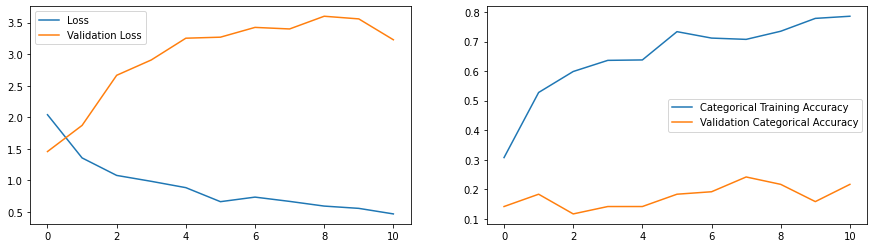

In [38]:
# Build the model
modelBuildAndExecute(Model2, parameters)

### <font color='#12558A'>Experiment number 4</font>
<font style="font-size:16px">Let us add more layers to the Model and take a batch size of 20</font>

In [39]:
class Model3:
  def __init__(self, parameters):
        model = Sequential()
        model.add(Conv3D(16, 
                         kernel_size=parameters['modelParams']['kernelSize'], 
                         input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3),
                         padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(16, parameters['modelParams']['kernelSize'], padding='same',
                 input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, parameters['modelParams']['kernelSize'], padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, parameters['modelParams']['kernelSize'], padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, parameters['modelParams']['kernelSize'], padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, parameters['modelParams']['kernelSize'], padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, parameters['modelParams']['kernelSize'], padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, parameters['modelParams']['kernelSize'], padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(parameters['modelParams']['dropout']))

        model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(parameters['modelParams']['dropout']))


        model.add(Dense(5,activation='softmax'))

        optimiser = parameters['modelParams']['optimiser']
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        self.model = model
  
  def build(self):
          return self.model

#### Let us update the batch size to 20, number of frames to sample as 16, image width and height as 120 and kernel size as (3,3,3)

In [40]:
parameters['batch_size']=20
parameters['sample_frames']=16
parameters['y']=120
parameters['z']=120
parameters['modelParams']['kernelSize'] =(3,3,3)
parameters['modelParams']['optimiser'] = Adam()
parameters

{'augmentMode': False,
 'batch_size': 20,
 'callbacks_list': [<keras.callbacks.ReduceLROnPlateau at 0x7fa066863810>,
 'modelParams': {'dropout': 0.5,
  'kernelSize': (3, 3, 3),
  'neurons': 256,
  'optimiser': <keras.optimizer_v2.adam.Adam at 0x7f9fc45b7890>},
 'num_epochs': 25,
 'sample_frames': 16,
 'x': 30,
 'y': 120,
 'z': 120}

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_38 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_33 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_33 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_39 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - 111s 3s/step - loss: 1.9530 - categorical_accuracy: 0.3574 - val_loss: 4.0096 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - 109s 3s/step - loss: 1.7331 - categorical_accuracy: 0.4221 - val_loss: 6.6970 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - 106s 3s/step - loss: 1.4374 - categorical_accuracy: 0.4779 - val_loss: 7.0954 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 4/25
34/34 [==============================] - 105s 3s/step - loss: 1.1866 - categorical_accuracy: 0.5500 - val_loss: 11.3126 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 5/25
34/34 [==============================] - ETA: 0s - loss: 1.1818 - categorical_accuracy: 0.5618
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
34/34 [==============================] - 103s 3s/step - loss: 1.1818 - categorical_accuracy: 0.5618 -

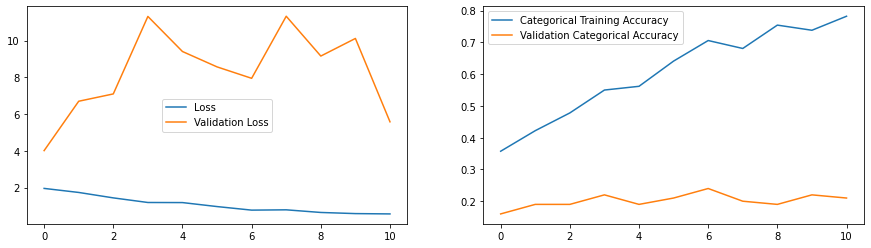

In [41]:
# Build the model
modelBuildAndExecute(Model3, parameters)

### <font color='#12558A'>Experiment number 5</font>
<font style="font-size:16px">Let us add dropout at the Convolution layers and use 15 epochs</font>

In [ ]:
class Model4:
  def __init__(self, parameters):
    model = Sequential()
    model.add(Conv3D(16, parameters['modelParams']['kernelSize'], padding='same',
                 input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(Conv3D(16, parameters['modelParams']['kernelSize'], padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(parameters['modelParams']['dropout']))
    model.add(Conv3D(32, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv3D(32, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(parameters['modelParams']['dropout']))

    model.add(Conv3D(64, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(Conv3D(64, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(parameters['modelParams']['dropout']))

    model.add(Conv3D(128, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(Conv3D(128, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(parameters['modelParams']['dropout']))
        
    model.add(Flatten())
    model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(parameters['modelParams']['dropout']))

    model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(parameters['modelParams']['dropout']))

    model.add(Dense(self.num_classes,activation='softmax'))
    optimiser = parameters['modelParams']['optimiser']
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    self.model= model
  def build(self):
    return self.model

#### Now let us take 15 epochs and execute the model

In [ ]:
parameters['num_epochs']=15
parameters

In [ ]:
# Build the model
modelBuildAndExecute(Model4, parameters)

### <font color='#12558A'>Experiment number 6</font>
<font style="font-size:16px">Let us reduce the number of parameters</font>

In [ ]:
class Model5:
     def __init__(self, parameters): 
        model = Sequential()
        model.add(Conv3D(16, 
                         kernel_size=parameters['modelParams']['kernelSize'], 
                         input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3),
                         padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(parameters['modelParams']['dropout']))

        model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(parameters['modelParams']['dropout']))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = parameters['modelParams']['optimiser']
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        self.model= model

     def build(self):
       return self.model

In [ ]:
# Set the following parameters
parameters['batch_size']=20 # Batch size
parameters['num_epochs']=20 # Number of Epochs
parameters['sample_frames']=16 # number of frames to sample
parameters['y']=100 # Width of the image
parameters['z']=100 # height of the image
parameters['modelParams']['kernelSize'] =(3,3,3) # filter size
parameters['modelParams']['neurons']=128 # Number of neurons in Dense layer
parameters['modelParams']['dropout'] = 0.25 # Dropout 
parameters['modelParams']['optimiser'] = Adam(lr=0.0002) # Optimiser
parameters

In [ ]:
# Build the model
modelBuildAndExecute(Model5, parameters)

### <font color='#12558A'>Experiment number 7</font>
<font style="font-size:16px">Let us further reduce the number of parameters and enable augmentation</font>

In [49]:
class Model6:
  def __init__(self, parameters):
    model = Sequential()
    model.add(Conv3D(16, parameters['modelParams']['kernelSize'], padding='same',
                 input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
    model.add(Flatten())
    model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(parameters['modelParams']['dropout']))

    model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(parameters['modelParams']['dropout']))

    model.add(Dense(5,activation='softmax'))
    optimiser = parameters['modelParams']['optimiser']
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    self.model= model
	
  def build(self):
    return self.model

In [50]:
# Set the following parameters
parameters['batch_size']=20 # Batch size
parameters['num_epochs']=25 # Number of Epochs
parameters['sample_frames']=16 # number of frames to sample
parameters['y']=120 # Width of the image
parameters['z']=120 # height of the image
parameters['modelParams']['kernelSize'] =(3,3,3) # filter size
parameters['modelParams']['neurons']=64 # Number of neurons in Dense layer
parameters['modelParams']['dropout'] = 0.25 # Dropout 
parameters['modelParams']['optimiser'] = Adam(lr=0.0002) # Optimiser
parameters

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


{'augmentMode': True,
 'batch_size': 20,
 'callbacks_list': [<keras.callbacks.ReduceLROnPlateau at 0x7fa066863810>,
 'modelParams': {'dropout': 0.25,
  'kernelSize': (3, 3, 3),
  'neurons': 64,
  'optimiser': <keras.optimizer_v2.adam.Adam at 0x7f9fbc0aaf50>},
 'num_epochs': 25,
 'sample_frames': 16,
 'x': 30,
 'y': 120,
 'z': 120}

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_45 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_45 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_55 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_46 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_46 (Activation)  (None, 8, 60, 60, 32)   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
34/34 [==============================] - 113s 3s/step - loss: 1.9789 - categorical_accuracy: 0.2786 - val_loss: 1.6991 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - 108s 3s/step - loss: 1.2501 - categorical_accuracy: 0.4729 - val_loss: 2.3348 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - 110s 3s/step - loss: 0.9744 - categorical_accuracy: 0.5900 - val_loss: 2.7892 - val_categorical_accuracy: 0.1100 - lr: 2.0000e-04
Epoch 4/25
34/34 [==============================] - 107s 3s/step - loss: 0.8191 - categorical_accuracy: 0.6429 - val_loss: 2.8825 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 5/25
34/34 [==============================] - ETA: 0s - loss: 0.6922 - categorical_accuracy: 0.7057
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
34/34 [==============================] - 105s 3s/step - loss: 0.6922 - categorical_acc

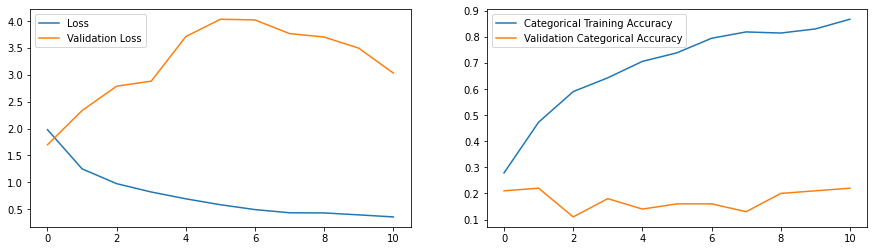

In [51]:
# Build the model
modelBuildAndExecute(Model6, parameters, augmentMode=True)

### <font color='#12558A'>Experiment number 8</font>
<font style="font-size:16px">Let us implement CNN-LSTM Model</font>

In [60]:
class CNNLSTMModel:
  def __init__(self, parameters):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(parameters['modelParams']['lstmNodes']))
    model.add(Dropout(parameters['modelParams']['dropout']))
    model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
    model.add(Dropout(parameters['modelParams']['dropout']))
        
    model.add(Dense(5, activation='softmax'))
    optimiser = parameters['modelParams']['optimiser']
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    self.model= model
	
  def build(self):
    return self.model

In [65]:
# Set the following parameters
parameters['batch_size']=20 # Batch size
parameters['num_epochs']=20 # Number of Epochs
parameters['sample_frames']=30 # number of frames to sample
parameters['y']=120 # Width of the image
parameters['z']=120 # height of the image
parameters['modelParams']['lstmNodes']=128
parameters['modelParams']['kernelSize'] =(3,3,3) # filter size
parameters['modelParams']['neurons']=128 # Number of neurons in Dense layer
parameters['modelParams']['dropout'] = 0.25 # Dropout 
parameters['modelParams']['optimiser'] = Adam() # Optimiser
parameters

{'augmentMode': True,
 'batch_size': 20,
 'callbacks_list': [<keras.callbacks.ReduceLROnPlateau at 0x7fa066863810>,
 'modelParams': {'dropout': 0.25,
  'kernelSize': (3, 3, 3),
  'lstmNodes': 128,
  'neurons': 128,
  'optimiser': <keras.optimizer_v2.adam.Adam at 0x7f9ecc530b10>},
 'num_epochs': 20,
 'sample_frames': 30,
 'x': 30,
 'y': 120,
 'z': 120}

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 60, 60, 32) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
34/34 [==============================] - 203s 6s/step - loss: 1.4029 - categorical_accuracy: 0.3343 - val_loss: 1.5904 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 195s 6s/step - loss: 1.2042 - categorical_accuracy: 0.4557 - val_loss: 1.6709 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - 197s 6s/step - loss: 1.1368 - categorical_accuracy: 0.4457 - val_loss: 1.7099 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 4/20
34/34 [==============================] - 191s 6s/step - loss: 1.0011 - categorical_accuracy: 0.5443 - val_loss: 1.8389 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 5/20
34/34 [==============================] - ETA: 0s - loss: 1.0099 - categorical_accuracy: 0.5314
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
34/34 [==============================] - 192s 6s/step - loss: 1.0099 - categorical_accuracy: 0.5314 - 

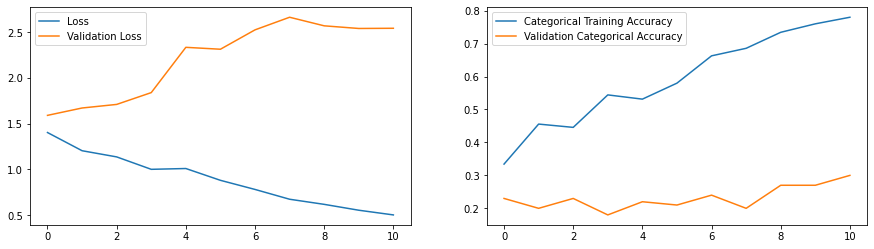

In [66]:
# Build the model
modelBuildAndExecute(CNNLSTMModel, parameters, augmentMode=True)

### <font color='#12558A'>Experiment number 9</font>
<font style="font-size:16px">Let us try another model with augmentation</font>

In [77]:
class Model8:
  def __init__(self, parameters):
    model = Sequential()
    model.add(Conv3D(16, parameters['modelParams']['kernelSize'], padding='same',
                 input_shape=(parameters["sample_frames"], parameters["y"], parameters["z"], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, parameters['modelParams']['kernelSize'], padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(parameters['modelParams']['dropout']))

    model.add(Dense(parameters['modelParams']['neurons'],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(parameters['modelParams']['dropout']))
    optimiser = parameters['modelParams']['optimiser']
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    self.model= model
	
  def build(self):
    return self.model

In [85]:
# Set the following parameters
parameters['batch_size']=30 # Batch size
parameters['num_epochs']=25 # Number of Epochs
parameters['sample_frames']=25 # number of frames to sample
parameters['y']=120 # Width of the image
parameters['z']=120 # height of the image
parameters['modelParams']['kernelSize'] =(2,2,2) # filter size
parameters['modelParams']['neurons']=256 # Number of neurons in Dense layer
parameters['modelParams']['dropout'] = 0.5 # Dropout 
parameters['modelParams']['optimiser'] = Adam(lr=0.0002) # Optimiser
parameters

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


{'augmentMode': True,
 'batch_size': 30,
 'callbacks_list': [<keras.callbacks.ReduceLROnPlateau at 0x7fa066863810>,
 'modelParams': {'dropout': 0.5,
  'kernelSize': (2, 2, 2),
  'lstmNodes': 128,
  'neurons': 256,
  'optimiser': <keras.optimizer_v2.adam.Adam at 0x7f9fc5162510>},
 'num_epochs': 25,
 'sample_frames': 25,
 'x': 30,
 'y': 120,
 'z': 120}

In [87]:
# Build the model
modelBuildAndExecute(Model8, parameters, augmentMode=True)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_77 (Conv3D)          (None, 25, 120, 120, 16)  400       
                                                                 
 activation_77 (Activation)  (None, 25, 120, 120, 16)  0         
                                                                 
 batch_normalization_128 (Ba  (None, 25, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_72 (MaxPoolin  (None, 12, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_78 (Conv3D)          (None, 12, 60, 60, 32)    4128      
                                                                 
 activation_78 (Activation)  (None, 12, 60, 60, 32)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25


InvalidArgumentError: ignored